# Подготвка расчетной сетки с данными батиметрии Бечевинской бухты

## Источники данных

* Глобальная сетка [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) по батиметрии;
* Карты генерального штаба и их аналоги ([ссылка](http://www.etomesto.ru/map-kamchatka_topokarta/)), а также материалы из отчета. 

Привязка картографических материалов и интерполяция по оцифрованной модели территории/акватории осуществлялась при помощи инструментария QGIS.

In [2]:
import os
import numpy as np
from netCDF4 import Dataset

import geopandas as gpd
import rasterio
from rasterio import features

from matplotlib import pyplot as plt
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

## Загрузка данных с примером охвата и визуализация

In [3]:
file_path = 'D:/Bechev/bathy_bechevink.nc'
netcdf_file = Dataset(file_path)

netcdf_file.variables

OrderedDict([('lon', <class 'netCDF4._netCDF4.Variable'>
              float64 lon(lon)
                  standard_name: longitude
                  long_name: longitude
                  units: degrees_east
                  axis: X
              unlimited dimensions: 
              current shape = (278,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lat', <class 'netCDF4._netCDF4.Variable'>
              float64 lat(lat)
                  standard_name: latitude
                  long_name: latitude
                  units: degrees_north
                  axis: Y
              unlimited dimensions: 
              current shape = (84,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('elevation', <class 'netCDF4._netCDF4.Variable'>
              int16 elevation(lat, lon)
                  standard_name: height_above_reference_ellipsoid
                  long_name: Elevation relative to sea level
  

Размер матрицы (84, 278)
Вектор долгот: [159.442965 ... 159.85873766266096]
Вектор широт: [53.200597 ... 53.27568294174055]


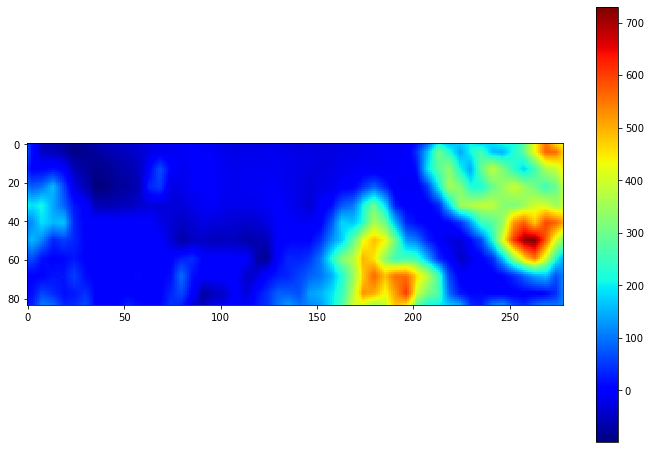

"Левый нижний" угол: широта - 53.200597, долгота - 159.442965
"Правый верхний" угол: широта - 53.27568294174055, долгота - 159.85873766266096
Размах по широте - 0.0750859417405465
Размах по долготе - 0.4157726626609701 

Пространственное разрешение по широте 0.0008938802588160298
Пространственное разрешение по долготе 0.001495585117485504


In [4]:
elevation_matrix = np.array(netcdf_file.variables['elevation'])
lon_vector = np.array(netcdf_file.variables['lon'])
lat_vector = np.array(netcdf_file.variables['lat'])

print(f'Размер матрицы {elevation_matrix.shape}')
print(f'Вектор долгот: [{lon_vector[0]} ... {lon_vector[-1]}]')
print(f'Вектор широт: [{lat_vector[0]} ... {lat_vector[-1]}]')

cmap = cm.get_cmap('jet')
plt.imshow(elevation_matrix, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show()      

print(f'"Левый нижний" угол: широта - {min(lat_vector)}, долгота - {min(lon_vector)}')
print(f'"Правый верхний" угол: широта - {max(lat_vector)}, долгота - {max(lon_vector)}')

scope_lat = max(lat_vector) - min(lat_vector)
scope_lon = max(lon_vector) - min(lon_vector)

print(f'Размах по широте - {scope_lat}')
print(f'Размах по долготе - {scope_lon} \n')

print(f'Пространственное разрешение по широте {scope_lat/elevation_matrix.shape[0]}')
print(f'Пространственное разрешение по долготе {scope_lon/elevation_matrix.shape[1]}')

## Формирование geotiff файла с актуальными данными

Все действия до данного этапа производились в геоинформационной системе QGIS.

In [5]:
# Матрица с глубинами без учета подходного канала
rst = rasterio.open("D:/Bechev/interpolated.tif")

# Матрица глубин с подходным каналом включенным в цифровую модель
rst_update = rasterio.open("D:/Bechev/interpolated_update.tif")

# Посмотрим на границы полученного изображения
# (можем использовать одно, так как по охвату они идентичны)
print(rst_update.bounds)
print(rst_update.crs)

BoundingBox(left=159.33906, bottom=53.057431, right=159.869758341, top=53.310172419)
EPSG:4326


Охват был взят с запасом.

In [6]:
# Прочитаем единтсвенный канал в открытом файле
array = rst.read(1)
array_update = rst_update.read(1)

print(f'Размер матриц: {array_update.shape}')

Размер матриц: (501, 1051)


Сушу обозначим белым цветом.

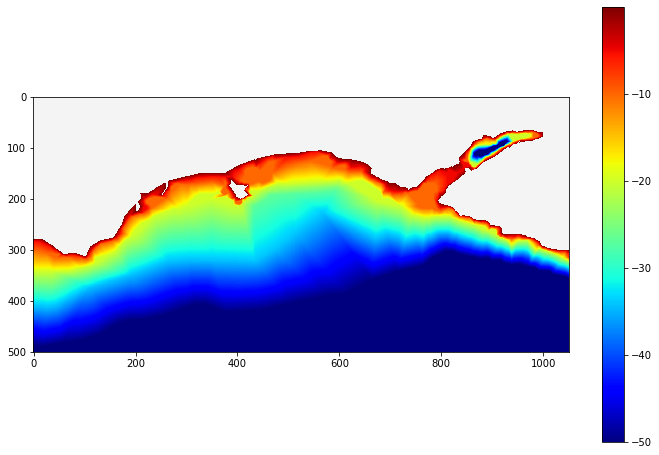

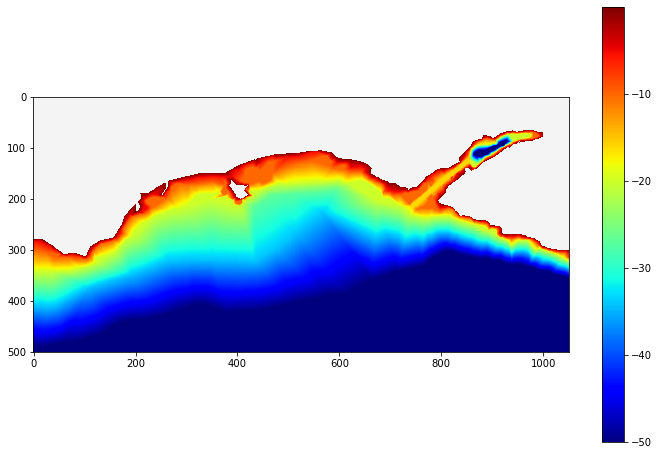

In [7]:
for matrix in [array, array_update]:
    masked_array = np.ma.masked_where(matrix > 0.0, matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='#F4F4F4')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.show()    

Функция для перевода заданного geotiff файла в формат netCDF (Коля, итс онли фо ю):
* param: geotiff_path - путь до geotiff файла
* param: netcdf_path - куда требуется сохранить netcdf файл


* return: конвертирует геотифф файл в нужный netcdf файл

In [8]:
def geotiff_to_netcdf(geotiff_path, netcdf_path):
    rst = rasterio.open(geotiff_path)
    bounds = list(rst.bounds)
    
    # Получаем матрицу со значениями глубин
    array = rst.read(1)
    array = np.flipud(array)
    matrix_shape = array.shape
    
    # Количество элементов вдоль осей
    lat_elements = matrix_shape[0]
    lon_elements = matrix_shape[1]
    
    # Размах по широте (lat) и долготе (lon)
    # left - 0, bottom - 1, right - 2, top - 3
    lat_range = np.linspace(bounds[1], bounds[3], num=lat_elements)
    lon_range = np.linspace(bounds[0], bounds[2], num=lon_elements)
    
    # Создем netcdf файл
    root_grp = Dataset(netcdf_path, 'w', format='NETCDF4')
    root_grp.description = 'Bathymetry data'
    root_grp.createDimension('lat', matrix_shape[0])
    root_grp.createDimension('lon', matrix_shape[1])
    
    # Записываем данные в файл
    lat = root_grp.createVariable('lat', 'double', ('lat',))
    lon = root_grp.createVariable('lon', 'double', ('lon',))
    data = root_grp.createVariable('elevation', 'float32', ('lat', 'lon'))
    
    lat.standard_name = 'latitude'
    lat.long_name = 'latitude'
    lat.units = 'degrees_north'
    lat._CoordinateAxisType = "Lat"

    lon.standard_name = 'longitude'
    lon.long_name = 'longitude'
    lon.units = 'degrees_east'
    lon._CoordinateAxisType = "Lon"

    data.units = 'm'
    data.long_name = 'bathy'
    data.standard_name = 'bathy'
    data.coordinates='lat lon'

    lat[:] = lat_range
    lon[:] = lon_range
    data[:] = array
    
    root_grp.close()
geotiff_to_netcdf(geotiff_path = "D:/Bechev/interpolated_update.tif", 
                  netcdf_path = "D:/Bechev/bathymetry_bech_update.nc")

Проверим корректно ли была произведена запись

In [9]:
netcdf_file = Dataset("D:/Bechev/bathymetry_bech_update.nc")
netcdf_file.variables

OrderedDict([('lat', <class 'netCDF4._netCDF4.Variable'>
              float64 lat(lat)
                  standard_name: latitude
                  long_name: latitude
                  units: degrees_north
                  _CoordinateAxisType: Lat
              unlimited dimensions: 
              current shape = (501,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lon', <class 'netCDF4._netCDF4.Variable'>
              float64 lon(lon)
                  standard_name: longitude
                  long_name: longitude
                  units: degrees_east
                  _CoordinateAxisType: Lon
              unlimited dimensions: 
              current shape = (1051,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('elevation', <class 'netCDF4._netCDF4.Variable'>
              float32 elevation(lat, lon)
                  units: m
                  long_name: bathy
                  standard_na

Размер матрицы (501, 1051)
Вектор долгот: [159.33906 ... 159.869758341]
Вектор широт: [53.057431 ... 53.310172419]


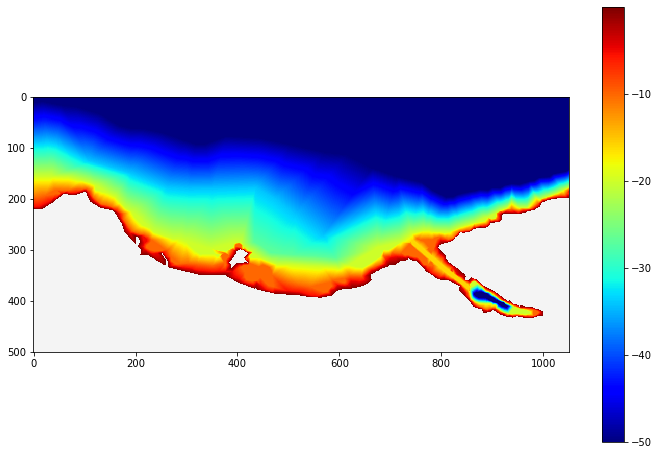

In [10]:
bathymetry_matrix = np.array(netcdf_file.variables['elevation'])
lon_vector = np.array(netcdf_file.variables['lon'])
lat_vector = np.array(netcdf_file.variables['lat'])

print(f'Размер матрицы {bathymetry_matrix.shape}')
print(f'Вектор долгот: [{lon_vector[0]} ... {lon_vector[-1]}]')
print(f'Вектор широт: [{lat_vector[0]} ... {lat_vector[-1]}]')

masked_array = np.ma.masked_where(bathymetry_matrix > 0.0, bathymetry_matrix)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='#F4F4F4')
plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show() 

Да, запись была произведена корректно. Сохраним еще матрицу без канала на всякий случай.

In [11]:
geotiff_to_netcdf(geotiff_path = "D:/Bechev/interpolated.tif", 
                  netcdf_path = "D:/Bechev/bathymetry_bech.nc")